In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import imageio.v3 as iio
import cvxpy as cvx

## L1 vs. L2 fitting: an example

In [4]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 1.123519
         Iterations: 47
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 0.135457
         Iterations: 51
         Function evaluations: 100


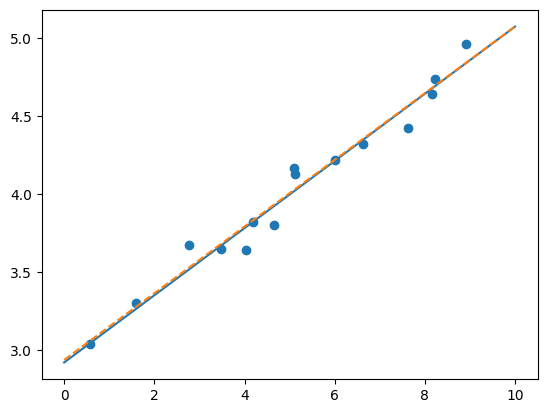

In [5]:
f = lambda opt, x: opt[1] + opt[0] * x
xs = np.linspace(0, 10)
plt.plot(xs, f(xopt1, xs))
plt.plot(xs, f(xopt2, xs), linestyle="--")
plt.scatter(x, y)

In [6]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

Optimization terminated successfully.
         Current function value: 7.920819
         Iterations: 55
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 21.620959
         Iterations: 49
         Function evaluations: 95


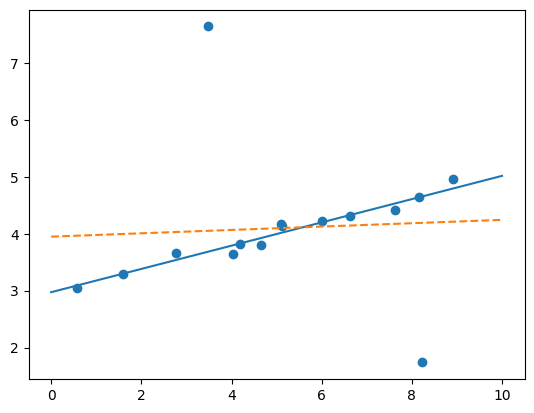

In [7]:
f = lambda opt, x: opt[1] + opt[0] * x
xs = np.linspace(0, 10)
plt.plot(xs, f(xopt12, xs))
plt.plot(xs, f(xopt22, xs), linestyle="--")
plt.scatter(x, y2)

## Simple signals

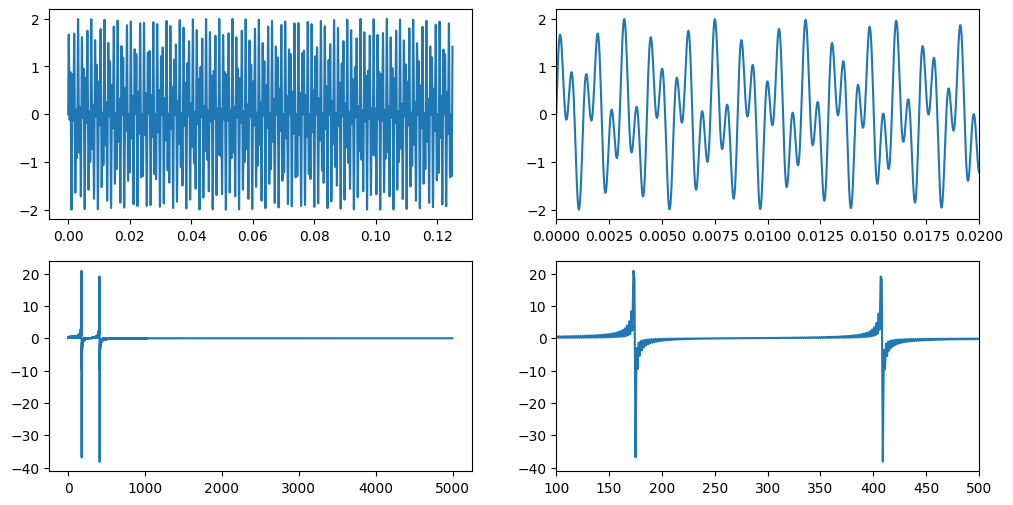

In [8]:
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1); plt.plot(t, y)
plt.subplot(2, 2, 2); plt.plot(t, y); plt.xlim(0, .02)
plt.subplot(2, 2, 3); plt.plot(yt)
plt.subplot(2, 2, 4); plt.plot(yt); plt.xlim(100, 500)
plt.show()

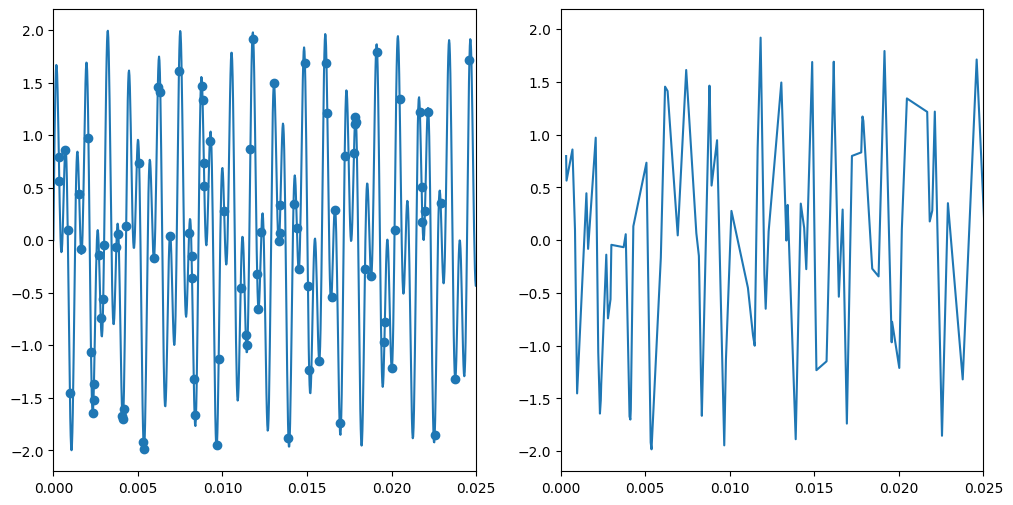

In [9]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.plot(t, y); plt.scatter(t2, y2); plt.xlim(0, 0.025)
plt.subplot(1, 2, 2); plt.plot(t2, y2); plt.xlim(0, .025)
plt.show()

In [10]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A@vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 02 06:57:10 PM: Your problem has 5000 variables, 500 constraints, and 0 parameters.
(CVXPY) Apr 02 06:57:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 02 06:57:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 02 06:57:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 02 06:57:10 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 02 06:57:10 PM: Compiling problem (target solver=CLARABE

(0.0, 0.025)

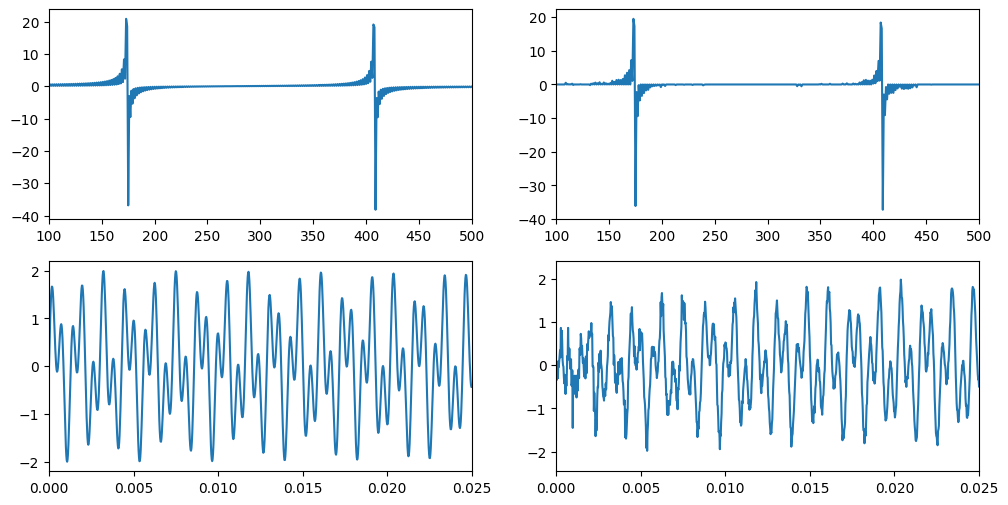

In [11]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1); plt.plot(yt); plt.xlim(100, 500)
plt.subplot(2, 2, 2); plt.plot(x); plt.xlim(100, 500)
plt.subplot(2, 2, 3); plt.plot(t, y); plt.xlim(0, .025)
plt.subplot(2, 2, 4); plt.plot(t, sig); plt.xlim(0, .025)

The artifact at $t=0$ is due to violation of _periodic boundary conditions_.
The cosine transform only really works for periodic signals, which we have assumed this isn't.

## 2D signal: an image

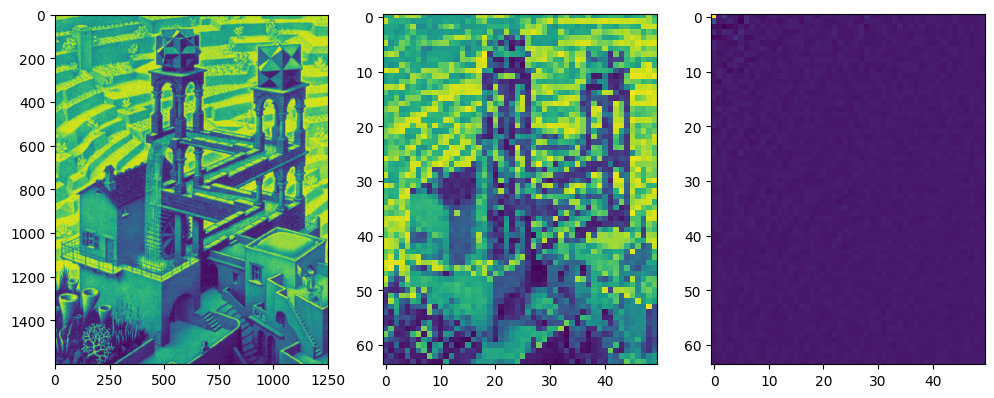

In [12]:
def dct2(x):
    return spfft.dct(spfft.dct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def idct2(x):
    return spfft.idct(spfft.idct(x, norm='ortho', axis=0), norm='ortho', axis=1)

# read original image and downsize for speed
# Xorig = iio.imread('image.jpg', mode='L') # read in grayscale
Xorig = iio.imread('Escher_Waterfall.jpg', mode='L') # read in grayscale
X = spimg.zoom(Xorig, 0.04)
ny, nx = X.shape

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(Xorig)
plt.subplot(1, 3, 2); plt.imshow(X)
plt.subplot(1, 3, 3); plt.imshow(dct2(X))

In [13]:
# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A@vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 02 06:57:24 PM: Your problem has 3200 variables, 1600 constraints, and 0 parameters.
(CVXPY) Apr 02 06:57:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 02 06:57:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 02 06:57:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 02 06:57:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 02 06:57:24 PM: Compiling problem (target solver=CLARAB

In [14]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

# create images of mask (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

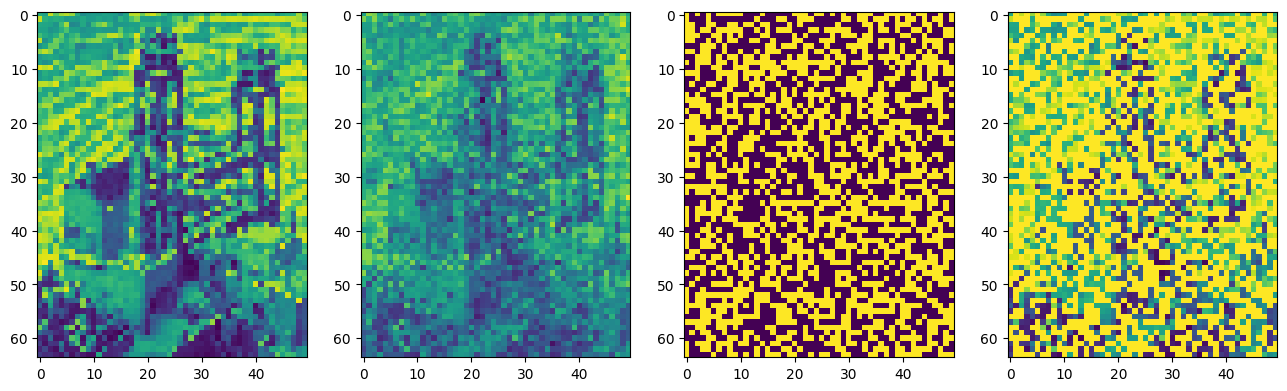

In [15]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 4, 1); plt.imshow(X)
plt.subplot(1, 4, 2); plt.imshow(Xa)
plt.subplot(1, 4, 3); plt.imshow(mask)
plt.subplot(1, 4, 4); plt.imshow(Xm)

Scalability is an issue with this approach.
The Kronecker product becomes unwieldy for large images.
Storing A as a dense matrix is prohibitive for images of normal resolutions.

## A full image: L2 minimization problem

In [ ]:
from scipy.optimize import minimize

def evaluate(x):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    # fx = np.sum(Axb**2)
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    # np.copyto(g, AtAxb)

    return fx, AtAxb

# fractions of the scaled image to randomly sample at
sample_sizes = (0.1, 0.01)

# read original image
# Xorig = iio.imread("image.jpg")
# Xorig = iio.imread('testimage.png')
Xorig = iio.imread("Escher_Waterfall.jpg")
ny,nx,nchan = Xorig.shape

# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    
    # for each color channel
    for j in range(nchan):
        
        # extract channel
        X = Xorig[:,:,j].squeeze()
        
        # create images of mask (for visualization)
        Xm = 255 * np.zeros(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:,j] = Xm
        
        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)
        
        # perform the L1 minimization in memory
        # Xat2 = owlqn(nx*ny, evaluate, None, 5)
        result = minimize(evaluate, np.zeros(nx*ny), method="L-BFGS-B", jac=True)

        # transform the output back into the spatial domain
        Xat = result.x.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        Z[i][:,:,j] = Xa.astype('uint8')

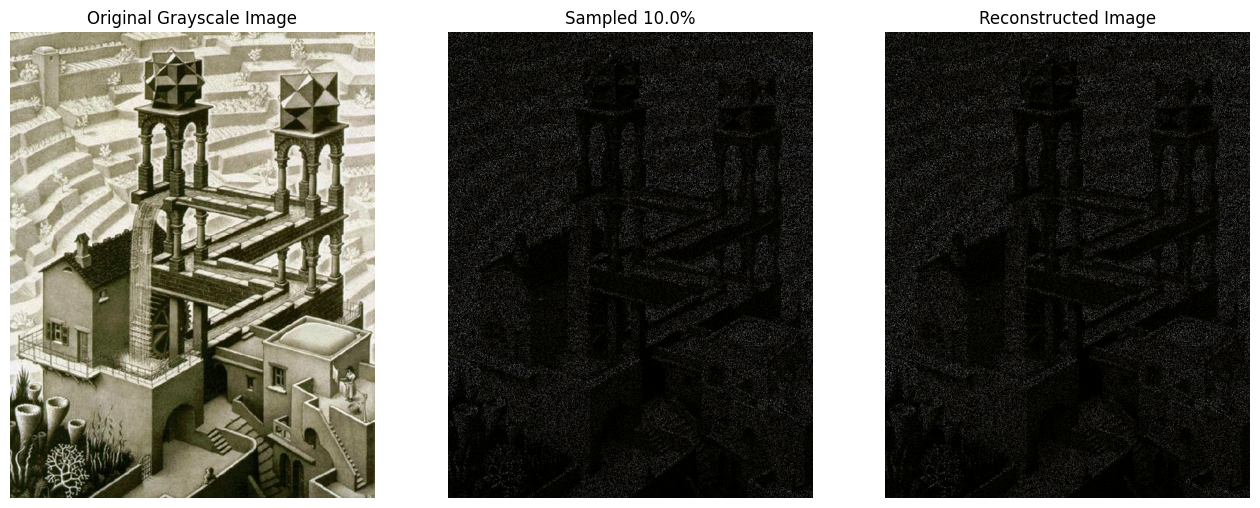

In [ ]:
plt.figure(figsize=(16, 8))
i = 0
plt.subplot(1, 3, 1); plt.imshow(Xorig, cmap='gray'); plt.title('Original Grayscale Image'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(masks[i], cmap='gray'); plt.title(f'Sampled {sample_sizes[i]*100:.1f}%'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(Z[i], cmap='gray'); plt.title('Reconstructed Image'); plt.axis('off')
plt.show()

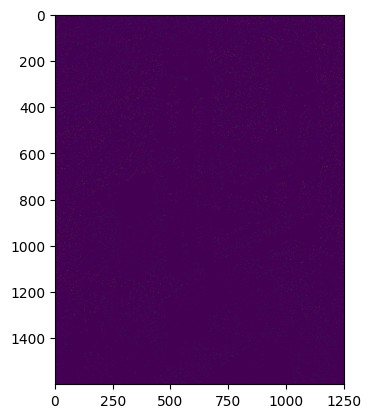

In [18]:
plt.imshow(Xa)

195318


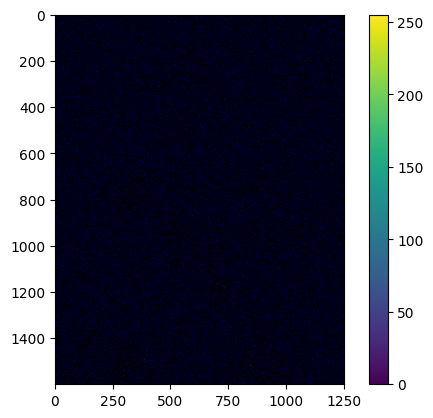

In [19]:
plt.imshow(Z[i] - masks[i]); plt.colorbar()
print(np.sum((Z[i] - masks[i])**2))

## A full image: L1 regularization

It is obvious that just minimizing the L2 norm of the residual is not enough.
The reconstructed image looks just like whatever we sampled, and all the pixels inbetween are balck, with no issue whatsoever.
This is because the L2 norm itself does not sufficiently enforce sparsity!

The intuition is straightforward.
The L2 norm penalizes the square of displacement, meaning that things far away are severly discouraged.
The L1 norm, on the other hand, does not care if the displacement comes from one far-away coefficient being pushed a bit closer in, or a nearby coefficient being pushed closer in.

    todo: fix this explanation



In [ ]:
# from scipy.optimize import minimize
from lbfgs import fmin_lbfgs

def evaluate(x, g):
    """An in-memory evaluation callback."""

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(Axb**2)
    # fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

def prog(x, g, fx, xnorm, gnorm, step, k, num_eval, *args):
    # print(f"xnorm: {xnorm:.3e}, gnorm: {gnorm:.3e}, iterations: {k}, evals: {num_eval}")
    if k%10 == 0: print(f"Iteration {k}: took {num_eval} evaluations to get gradient {gnorm:.3e}, total loss is {fx:.3e}.")
    return None

# fractions of the scaled image to randomly sample at
sample_sizes = (.01, .1, .25)

# read original image
Xorig = iio.imread("image.jpg")
# Xorig = iio.imread('testimage.png')
# Xorig = iio.imread("Escher_Waterfall.jpg", pilmode="L")
ny,nx,nchan = Xorig.shape

# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

    for j in range(nchan):
    
        # extract channel
        X = Xorig[:,:, j].squeeze()
        
        # create images of mask (for visualization)
        Xm = 255 * np.ones(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:, j] = Xm
        
        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)
        
        # perform the L1 minimization in memory
        # Xat2 = owlqn(nx*ny, evaluate, None, 5)
        # result = minimize(evaluate, np.zeros(nx*ny), method="L-BFGS-B", jac=True, options={"disp": True})
        # transform the output back into the spatial domain
        # Xat = result.x.reshape(nx, ny).T # stack columns

        # Xat2 = owlqn(nx * ny, evaluate, None, 5)
        Xat2 = fmin_lbfgs(evaluate, np.zeros((nx,ny)), prog, orthantwise_c=1, line_search="wolfe")
        Xat = Xat2.reshape(nx, ny).T

        Xa = idct2(Xat)
        Z[i][:,:, j] = Xa.astype('uint8')

Iteration 10: took 1 evaluations to get gradient 1.696e+02, total loss is 2.897e+06.
Iteration 20: took 4 evaluations to get gradient 5.368e+02, total loss is 2.209e+06.
Iteration 30: took 2 evaluations to get gradient 2.169e+02, total loss is 1.813e+06.
Iteration 40: took 1 evaluations to get gradient 1.091e+02, total loss is 1.365e+06.
Iteration 50: took 1 evaluations to get gradient 1.132e+02, total loss is 1.219e+06.
Iteration 60: took 1 evaluations to get gradient 7.488e+01, total loss is 1.075e+06.
Iteration 70: took 1 evaluations to get gradient 5.443e+01, total loss is 9.908e+05.
Iteration 80: took 1 evaluations to get gradient 3.979e+01, total loss is 9.454e+05.
Iteration 90: took 1 evaluations to get gradient 3.090e+01, total loss is 9.210e+05.
Iteration 100: took 1 evaluations to get gradient 2.082e+01, total loss is 9.055e+05.
Iteration 110: took 1 evaluations to get gradient 1.640e+01, total loss is 8.955e+05.
Iteration 120: took 1 evaluations to get gradient 1.462e+01, to

In [82]:
from tqdm import tqdm

def make_eval(b, ri):
    def evaluate(x, g):
        """An in-memory evaluation callback."""

        # expand x columns-first
        x2 = x.reshape((nx, ny)).T

        # Ax is just the inverse 2D dct of x2
        Ax2 = idct2(x2)
        # print(Ax2.T.flat[ri].shape)

        # stack columns and extract samples
        Ax = Ax2.T.flat[ri].reshape(b.shape)

        # calculate the residual Ax-b and its 2-norm squared
        Axb = Ax - b
        fx = np.sum(Axb**2)
        # fx = np.sum(np.power(Axb, 2))

        # project residual vector (k x 1) onto blank image (ny x nx)
        Axb2 = np.zeros(x2.shape)
        Axb2.T.flat[ri] = Axb # fill columns-first

        # A'(Ax-b) is just the 2D dct of Axb2
        AtAxb2 = 2 * dct2(Axb2)
        AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

        # copy over the gradient vector
        np.copyto(g, AtAxb)

        return fx
    
    return evaluate


def compressed_reconstruction_for_image(img: str, sample_sizes: list, mk_eval: callable, l1_reg: float, should_log=0):
    if should_log > 1:
        def prog(x, g, fx, xnorm, gnorm, step, k, num_eval, *args):
            # print(f"xnorm: {xnorm:.3e}, gnorm: {gnorm:.3e}, iterations: {k}, evals: {num_eval}")
            if k%10 == 0: print(f"Iteration {k}: took {num_eval} evaluations to get gradient {gnorm:.3e}, total loss is {fx:.3e}.")
            return None
    else:
        def prog(x, g, fx, xnorm, gnorm, step, k, num_eval, *args):
            return None

    Xorig = iio.imread(img)
    ny,nx,nchan = Xorig.shape

    Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
    masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
    
    for i,s in tqdm(enumerate(sample_sizes)):
        k = round(nx * ny * s)
        ri = np.random.choice(nx * ny, k, replace=False)
        if should_log > 0: print(f"k: {k}, ri: {ri.shape}")

        for j in range(nchan):
            X = Xorig[:,:, j].squeeze()
            
            Xm = 255 * np.ones(X.shape)
            Xm.T.flat[ri] = X.T.flat[ri]
            masks[i][:,:, j] = Xm
            
            b = X.T.flat[ri].astype(float)
            ev = mk_eval(b, ri)
            if should_log: print(f"b: {b.shape}")
            
            Xat2 = fmin_lbfgs(ev, np.zeros((nx,ny)), prog, orthantwise_c=l1_reg, line_search="wolfe",)
            Xat = Xat2.reshape(nx, ny).T
            Xa = idct2(Xat)
            Z[i][:,:, j] = Xa.astype('uint8')
    
    return Z, {"original": Xorig, "masks": masks, "sample_sizes": sample_sizes}

In [83]:
Z_01, diag_01 = compressed_reconstruction_for_image("image.jpg", [.25, .1, .01], make_eval, .1, should_log=True)
Z_1, diag_1 = compressed_reconstruction_for_image("image.jpg", [.25, .1, .01], make_eval, 1.0, should_log=True)
Z_10, diag_10 = compressed_reconstruction_for_image("image.jpg", [.25, .1, .01], make_eval, 10.0, should_log=True)
Z_100, diag_100 = compressed_reconstruction_for_image("image.jpg", [.25, .1, .01], make_eval, 100.0, should_log=True)

0it [00:00, ?it/s]

k: 140750, ri: (140750,)
b: (140750,)
b: (140750,)
b: (140750,)


1it [07:46, 466.56s/it]

k: 56300, ri: (56300,)
b: (56300,)
b: (56300,)
b: (56300,)


2it [14:40, 435.65s/it]

k: 5630, ri: (5630,)
b: (5630,)
b: (5630,)
b: (5630,)


3it [17:16, 345.59s/it]
0it [00:00, ?it/s]

k: 140750, ri: (140750,)
b: (140750,)
b: (140750,)
b: (140750,)


1it [01:27, 87.21s/it]

k: 56300, ri: (56300,)
b: (56300,)
b: (56300,)
b: (56300,)


2it [02:22, 68.41s/it]

k: 5630, ri: (5630,)
b: (5630,)
b: (5630,)
b: (5630,)


3it [03:05, 61.76s/it]
0it [00:00, ?it/s]

k: 140750, ri: (140750,)
b: (140750,)
b: (140750,)
b: (140750,)


1it [00:09,  9.39s/it]

k: 56300, ri: (56300,)
b: (56300,)
b: (56300,)
b: (56300,)


2it [00:19,  9.92s/it]

k: 5630, ri: (5630,)
b: (5630,)
b: (5630,)
b: (5630,)


3it [00:31, 10.35s/it]
0it [00:00, ?it/s]

k: 140750, ri: (140750,)
b: (140750,)
b: (140750,)
b: (140750,)


1it [00:04,  4.09s/it]

k: 56300, ri: (56300,)
b: (56300,)
b: (56300,)
b: (56300,)


2it [00:08,  4.52s/it]

k: 5630, ri: (5630,)
b: (5630,)
b: (5630,)
b: (5630,)


3it [01:19, 26.53s/it]


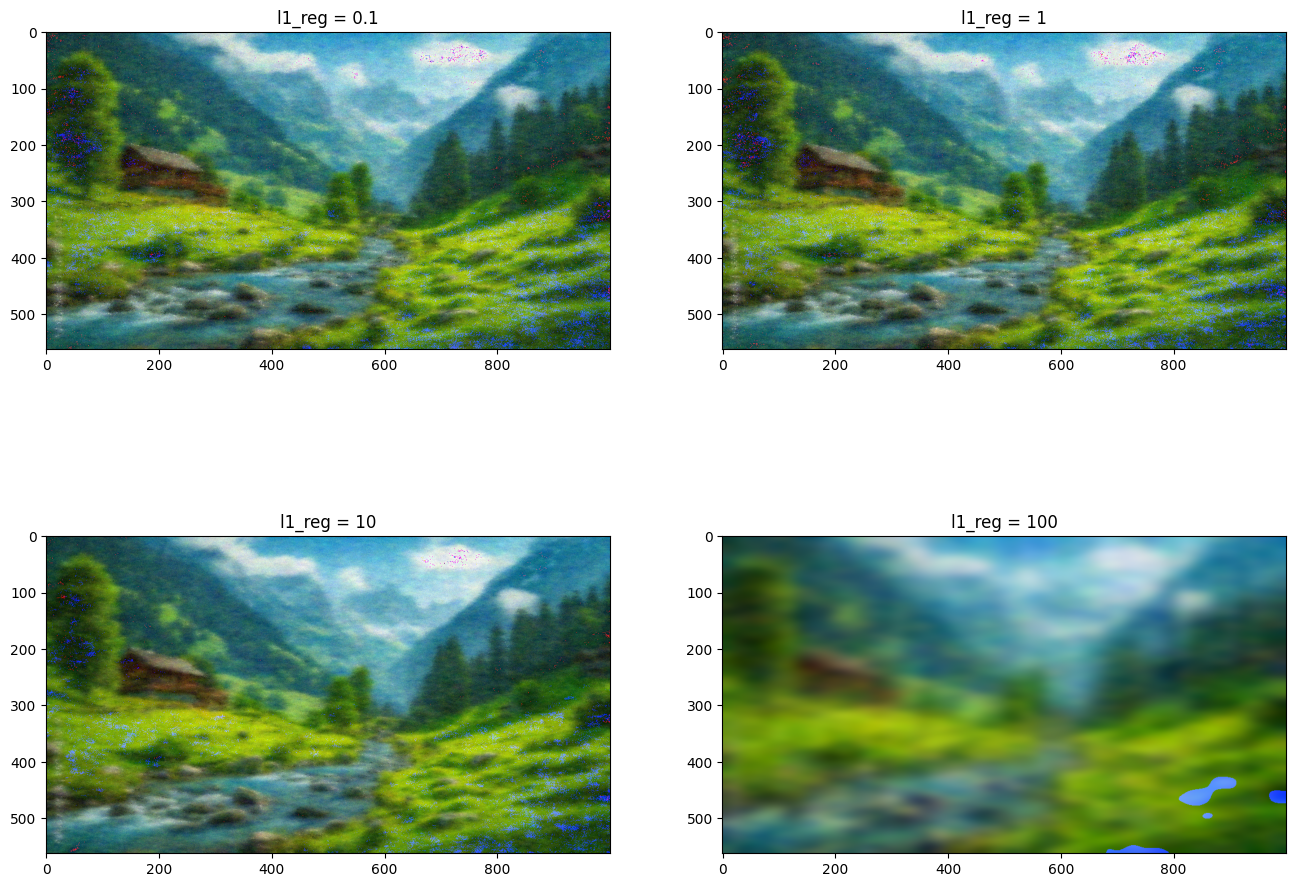

In [81]:
plt.figure(figsize=(16, 12))
i = 1
plt.subplot(2, 2, 1); plt.imshow(Z_01[i]); plt.title("l1_reg = 0.1")
plt.subplot(2, 2, 2); plt.imshow(Z_1[i]); plt.title("l1_reg = 1")
plt.subplot(2, 2, 3); plt.imshow(Z_10[i]); plt.title("l1_reg = 10")
plt.subplot(2, 2, 4); plt.imshow(Z_100[i]); plt.title("l1_reg = 100")
plt.show()

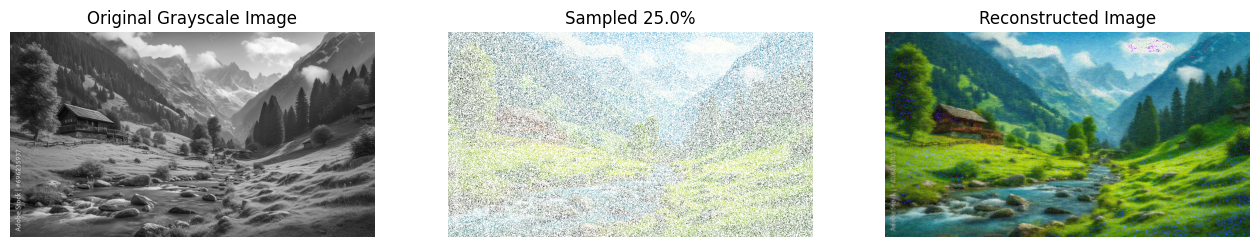

In [ ]:
plt.figure(figsize=(16, 8))
i = 2
plt.subplot(1, 3, 1); plt.imshow(Xorig, cmap='gray'); plt.title('Original Grayscale Image'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(masks[i], cmap='gray'); plt.title(f'Sampled {sample_sizes[i]*100:.1f}%'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(Z[i], cmap='gray'); plt.title('Reconstructed Image'); plt.axis('off')
plt.show()

## A full image: SLSQP

This is absolutely infeasible as the matrix would be much too large.
We need a _matrix free_ approach.

In [36]:
def L1_norm(x):
    return np.linalg.norm(x, ord=1)

sample_size = .1
Xorig = iio.imread("image.jpg", pilmode="L")
nx, ny = Xorig.shape
# k = round(nx * ny * sample_size)
# ri = np.random.choice(nx*ny, k, replace=False)

n = nx * ny
p = round(n * sample_size)

def my_eval(x):
    x2 = x.reshape((nx, ny)).T
    Ax2 = idct2(x2)
    Ax = Ax2.T.flat[ri].reshape(b.shape)
    Axb = Ax - b
    fx = np.sum(Axb**2)

    return fx + L1_norm(x)

X = Xorig[:, :].squeeze()
b = X.T.flat[ri].astype(float)

# cstr = ({"type": "eq",
#          "fun": lambda x: idct2(x.reshape((nx, ny)).T).T.flat[ri].reshape(b.shape) - b
#          })

# cstr["fun"](np.zeros((nx, ny)))

# x0 = np.linalg.pinv()
x0 = np.zeros((nx*ny,))
res = minimize(my_eval, x0, method="SLSQP")

# s_L1 = res.x


MemoryError: Unable to allocate 19.6 TiB for an array with shape (2694255923526,) and data type float64